## Visualization
Rosenbaum's test has a known, exact null distribution, which is exactly distribution free, meaning that the test works for any underlying distributions F and G which are tested on being equal. 
It constructs an optimal bi-partite matching of all observations, meaning that it pairs each data point to exactly one other, minimizing the within-pair distances.
If F and G are similar or equal, the matching will result in a high number of cross-matches (pairs with one observation from each of the groups). If they are different, the minimal distance pairs will mostly be from the same groups.    
This notebooks visualizes the Rosenbaum test with two distributions. 

#### Experiment with the distributions to see the effects on the matching!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
from graph_tool.all import Graph
import pandas as pd
import anndata as ad
import sys
sys.path.append("..")
from src import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import itertools
from scipy.spatial.distance import cdist
import time
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import networkx as nx
import string  # For (a), (b), (c), ... labels

np.random.seed(15)

/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:33: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:33: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:33: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


will use the CPU to calculate the distance matrix.


In [3]:
metric = "sqeuclidean"

In [20]:
n_obs_a = 45
n_obs_b = 55
n_var = 2
samples_A = np.random.normal(0, 0.5, [n_obs_a, n_var]) 
samples_B = np.random.normal(0.3, 0.5, [n_obs_b, n_var]) 

groups = ["A"] * n_obs_a + ["B"] * n_obs_b  
samples = np.concatenate((samples_A, samples_B)) 
adata_1 = ad.AnnData(samples)
adata_1.obs["Group"] = groups

In [21]:
def get_laid_out_matches(adata_1, matching):
    # for visualization purposes
    a1 = cross_match_count(adata_1.obs["Group"], matching, "A")
    num_points = 10
    x = np.linspace(-2, 2, num_points)
    y = np.linspace(-2, 2, int((n_obs_a + n_obs_b) / num_points))
    X, Y = np.meshgrid(x, y)
    coords = np.column_stack((X.ravel(), Y.ravel()))
    n = n_obs_a
    I = len(matching)
    a2 = int((n - a1) / 2)
    a0 = int(I - (n + a1) / 2)
    coords[2*a1: 2*(a1+a2)] += [0, 0.5]
    coords[2*(a1+a2):] += [0, 1]
    laid_out_pos = {i: -coords[i] for i in range(len(coords))}
    laid_out_colors = int(a1) * ["#A02B93", "#EFC41C"] + int(a2) * ["#EFC41C", "#EFC41C"] + int(a0) * ["#A02B93", "#A02B93"]
    laid_out_graph = nx.from_edgelist([(i, i+1) for i in range(0, 2 * int(a0 + a1 + a2), 2)])
    return laid_out_graph, laid_out_pos, laid_out_colors

In [22]:
start = time.time()
sc.pp.pca(adata_1)
sc.pp.neighbors(adata_1, metric=metric, n_pcs=0)

In [23]:
test = "A"
reference = "B"
metric="sqeuclidean"
distances = calculate_distances(adata_1.X, metric)
G = construct_graph_from_distances(distances)
matching = match(G, len(adata_1))

using CPU to calculate distance matrix.
creating distance graph with 100 samples


In [24]:
sc.pp.neighbors(adata_1, n_neighbors=5, metric=metric)

In [25]:
G = nx.from_edgelist([e for e in G.get_edges() if ((e[0] < len(adata_1) and e[1] < len(adata_1)) and (e[0] != e[1]))])
G_knn = nx.from_scipy_sparse_array(adata_1.obsp["distances"])

In [26]:
G_matching = nx.from_edgelist(matching)
for i in range(len(adata_1)):
    G_matching.add_node(i)

In [27]:
used_elements = list(chain.from_iterable(matching))
pos = {i: adata_1.X[i] for i in range(len(adata_1))}
pos_2 = {i: pos[i] + [0, np.max(adata_1.X)] for i in range(len(pos))}
pos_3 = {i: pos[i] + [0, -np.max(adata_1.X)] for i in range(len(pos))}

n_colors = adata_1.obs["Group"].replace({"A": "#A02B93", "B": "#EFC41C"}).values[G_matching.nodes]

In [28]:
n_samples = 100
means = [(0,0), (0,0), (0.75,0.75), (1.5,1.5), (0,0)]
covs = [(1,1), (1,1), (1,1), (1,1), (2,2)]
group_labels = ["A", "B", "C", "D", "E"]

samples = [np.random.normal(mean, cov, [n_samples, 2]) for mean, cov in zip(means, covs)]
groups = sum([[label] * n_samples for label in group_labels], [])
data = np.vstack(samples)
adata_2 = ad.AnnData(data)
adata_2.obs["Group"] = groups

group_colors = {"A": "purple", "B": "orange", "C": "green", "D": "pink", "E": "blue"}
group_means = dict(zip(group_labels, means))
group_covs = dict(zip(group_labels, covs))
references = ["B", "C", "D", "E"]


In [29]:
fig_1a = plt.imread("../plots/fig_1a.png")
laid_out_graph, laid_out_pos, laid_out_colors = get_laid_out_matches(adata_1, matching)

counting cross matches.


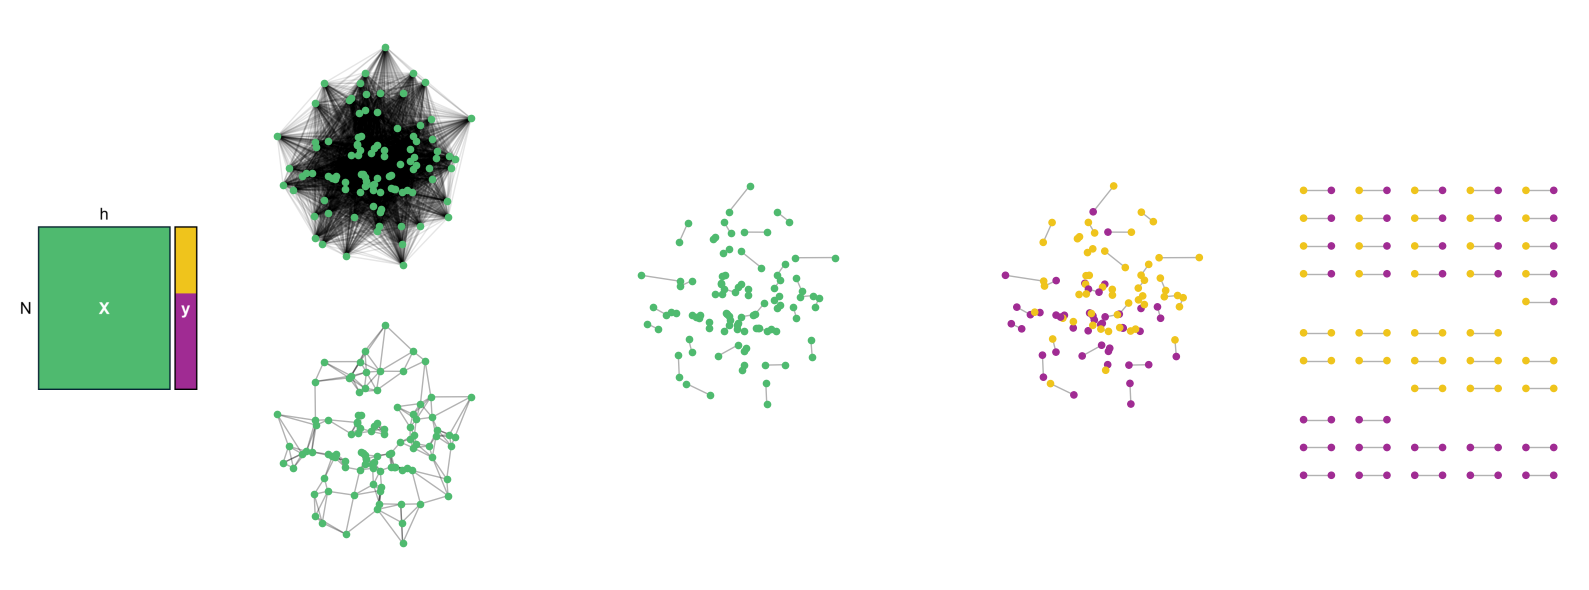

In [30]:
# Create figure and subplots
ratios = [0.5, 1, 1, 1, 0.8]
f, axs = plt.subplots(1, 5, figsize=(16, 6), width_ratios=ratios)

# Plot figures in first row
axs[0].imshow(fig_1a)
axs[0].axis("off")

nx.draw(G, pos=pos_2, node_color="#4FBA6F", edge_color=(0, 0, 0, 0.1), node_size=20, ax=axs[1])
nx.draw(G_knn, pos=pos_3, node_color="#4FBA6F", edge_color=(0, 0, 0, 0.3), node_size=20, ax=axs[1])
nx.draw(G_matching, pos=pos, node_color="#4FBA6F", edge_color=(0, 0, 0, 0.3), node_size=20, ax=axs[2])
nx.draw(G_matching, pos=pos, node_color=n_colors, edge_color=(0, 0, 0, 0.3), node_size=20, ax=axs[3])
nx.draw(laid_out_graph, pos=laid_out_pos, node_color=laid_out_colors, edge_color=(0, 0, 0, 0.3), node_size=20, ax=axs[4])

axs[1].set_aspect(1)


for ax in axs[2:5]:  # Sharing with axes[0,1]
    ax.sharey(axs[1])
    ax.set_aspect(1)

for ax in axs:  # Sharing with axes[0,1]
    ax.set_aspect(1)

plt.tight_layout()
plt.savefig("../plots/visualization_1a.svg", dpi=300, bbox_inches="tight")

/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")
/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")
/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")
/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.o

XMatch_group
test         100
reference    100
Name: count, dtype: int64
using CPU to calculate distance matrix.
creating distance graph with 200 samples
counting cross matches.
XMatch_group
test         100
reference    100
Name: count, dtype: int64
using CPU to calculate distance matrix.
creating distance graph with 200 samples
counting cross matches.
XMatch_group
test         100
reference    100
Name: count, dtype: int64
using CPU to calculate distance matrix.
creating distance graph with 200 samples
counting cross matches.
XMatch_group
test         100
reference    100
Name: count, dtype: int64
using CPU to calculate distance matrix.
creating distance graph with 200 samples
counting cross matches.


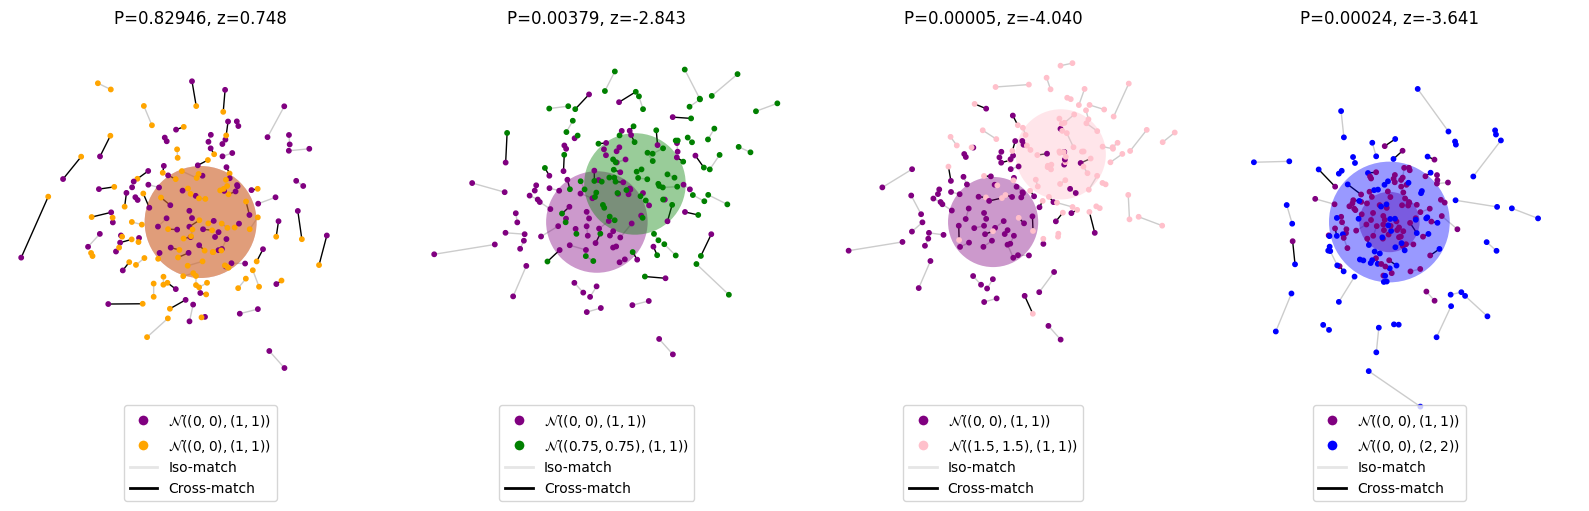

In [31]:
f, axs = plt.subplots(1, 4, figsize=(16, 8))

for ax in axs:  
    ax.set_aspect(1)

for i, reference in enumerate(references):
    adata_subset = adata_2[adata_2.obs["Group"].isin(["A", reference])]
    (p_val, z, support), _, matching_2 = rosenbaum(adata_subset, group_by="Group", test_group=test, reference=reference, return_matching=True)

    ax = axs[i]
    draw_matching(adata_subset, matching_2, p_val, z, support, ax, group_colors)

    for group, color in group_colors.items():
        if group == "A" or group == reference:
            draw_ellipse(ax, group_means[group], group_covs[group], color)

    max_val = np.max(np.abs(adata_subset.X)) + 0.2
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val, max_val)

    ax.legend(
        handles=legend_elements(groups=["A", reference], group_colors=group_colors, group_means=group_means, group_covs=group_covs),
        loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=1
    )
plt.tight_layout()
plt.savefig("../plots/2d_gaussians.svg", dpi=300, bbox_inches="tight")